In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import levene
from scipy.stats import ttest_ind

# Inference
We’re interested in attempting to infer a player’s age using a statistical model based on performance metrics.
We might expect that when a player is relatively old or young,
there will be a relationship between their performance metrics and their age.

### Null Hypothesis:
There is no relationship between performance metrics and a player’s age.

### Alternative Hypothesis:
There is a statistically significant relationship between performance metrics and a player’s age.

In [5]:
nba.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
4799,4.0,Julius Erving,29,PHI,SF,78.0,78.0,36.1,10.7,20.7,...,4.6,7.4,4.6,2.2,1.8,3.6,2.7,26.9,"MVP-2,AS,NBA1",1980
4812,17.0,Larry Bird,23,BOS,PF,82.0,82.0,36.0,8.5,17.8,...,7.8,10.4,4.5,1.7,0.6,3.2,3.4,21.3,"MVP-4,ROY-1,AS,NBA1",1980
4862,67.0,Dave Cowens,31,BOS,C,66.0,55.0,32.7,6.4,14.1,...,6.2,8.1,3.1,1.0,0.9,1.6,3.3,14.2,AS,1980
4866,71.0,Tiny Archibald,31,BOS,PG,80.0,80.0,35.8,4.8,9.9,...,1.7,2.5,8.4,1.3,0.1,3.0,2.7,14.1,"MVP-5,AS",1980
5089,7.0,Julius Erving,30,PHI,SF,82.0,82.0,35.0,9.7,18.6,...,5.0,8.0,4.4,2.1,1.8,3.2,2.8,24.6,"MVP-1,AS,NBA1",1981


Perhaps the most straightforward performance metric is points scored (`PTS`).
We will likely expand the number of variables that constitute a player’s performance metric, but let’s start small.

In [6]:
nba[['Age', 'PTS']].groupby('Age').mean()

,PTS
Age,
19,13.618919
20,14.557746
21,16.178409
22,17.089474
23,16.950000
24,18.265089
25,18.722105
26,18.296078
27,18.231500


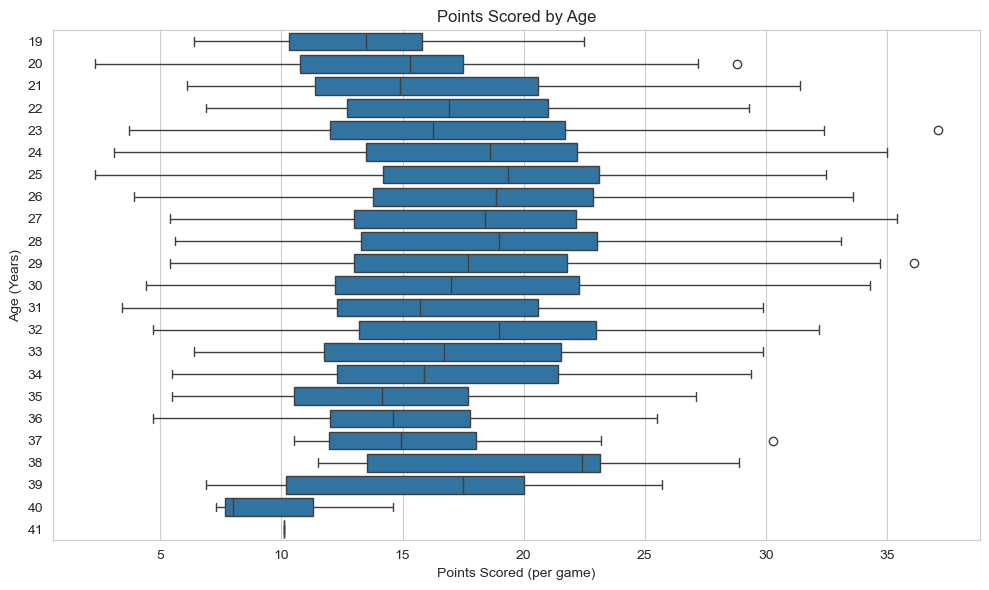

In [7]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=nba,
    x = 'PTS',
    y = 'Age',
    orient='h'
)

plt.title('Points Scored by Age')
plt.xlabel('Points Scored (per game)')
plt.ylabel('Age (Years)')


plt.tight_layout()
plt.show()

In [8]:
nba['Age'].value_counts()

Age
26    204
27    200
25    190
24    169
28    168
29    163
23    156
22    133
30    133
31    113
21     88
32     81
33     76
20     71
34     51
19     37
35     34
36     25
37     14
38      7
39      5
40      3
41      1
Name: count, dtype: int64

There's a decent number of samples for most of the ages except for 38, 39, 40,
and 41. We can resample our samples to get a better understanding of the variance in our sample means,
but there is not enough variation in 40 and 41. Therefore,
we will set these players’ age to 39 to act as a pseudo 39+ value.

In [9]:
nba[nba['Age'].isin([40, 41])]

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
7367,64.0,Kareem Abdul-Jabbar,40,LAL,C,80.0,80.0,28.9,6.0,11.3,...,4.5,6.0,1.7,0.6,1.2,2.0,2.7,14.6,AS,1988
7768,133.0,Kareem Abdul-Jabbar,41,LAL,C,74.0,74.0,22.9,4.2,8.9,...,3.1,4.5,1.0,0.5,1.1,1.3,2.6,10.1,AS,1989
20071,204.0,Vince Carter,40,MEM,SF,73.0,15.0,24.6,2.6,6.7,...,2.6,3.1,1.8,0.8,0.5,0.7,2.2,8.0,6MOY-11,2017
21151,256.0,Dirk Nowitzki,40,DAL,PF,51.0,20.0,15.6,2.6,7.4,...,3.0,3.1,0.7,0.2,0.4,0.4,1.5,7.3,AS,2019


In [10]:
nba.loc[nba['Age'] >= 40, 'Age'] = 39
nba[nba['Age'].isin([39])]

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
7009,41.0,Kareem Abdul-Jabbar,39,LAL,C,78.0,78.0,31.3,7.2,12.7,...,4.8,6.7,2.6,0.6,1.2,2.4,3.1,17.5,AS,1987
7367,64.0,Kareem Abdul-Jabbar,39,LAL,C,80.0,80.0,28.9,6.0,11.3,...,4.5,6.0,1.7,0.6,1.2,2.0,2.7,14.6,AS,1988
7768,133.0,Kareem Abdul-Jabbar,39,LAL,C,74.0,74.0,22.9,4.2,8.9,...,3.1,4.5,1.0,0.5,1.1,1.3,2.6,10.1,AS,1989
13446,26.0,Michael Jordan,39,WAS,SF,82.0,67.0,37.0,8.3,18.6,...,5.2,6.1,3.8,1.5,0.5,2.1,2.1,20.0,AS,2003
14971,214.0,Clifford Robinson,39,NJN,PF,80.0,13.0,23.3,2.7,6.4,...,2.7,3.3,1.1,0.6,0.5,0.8,2.6,6.9,6MOY-14,2006
17613,146.0,Grant Hill,39,PHO,SF,49.0,46.0,28.1,4.1,9.2,...,2.9,3.5,2.2,0.8,0.6,1.3,1.8,10.2,DPOY-14,2012
20071,204.0,Vince Carter,39,MEM,SF,73.0,15.0,24.6,2.6,6.7,...,2.6,3.1,1.8,0.8,0.5,0.7,2.2,8.0,6MOY-11,2017
21151,256.0,Dirk Nowitzki,39,DAL,PF,51.0,20.0,15.6,2.6,7.4,...,3.0,3.1,0.7,0.2,0.4,0.4,1.5,7.3,AS,2019
23658,15.0,LeBron James,39,LAL,PF,71.0,71.0,35.3,9.6,17.9,...,6.4,7.3,8.3,1.3,0.5,3.5,1.1,25.7,"CPOY-10,AS,NBA3",2024


In [11]:
age_26 = nba[nba['Age'] == 26]['PTS'].values
age_39_plus = nba[nba['Age'] == 39]['PTS'].values

age_26_means = []
age_39_plus_means = []

# Resampling
for i in range(10_000):
    age_26_resamp = np.random.choice(age_26, size=len(age_26))
    age_39_plus_resamp = np.random.choice(age_39_plus, size=len(age_39_plus))

    age_26_means.append(age_26_resamp.mean())
    age_39_plus_means.append(age_39_plus_resamp.mean())

# Convert lists to arrays
age_26_means = np.array(age_26_means)
age_39_plus_means = np.array(age_39_plus_means)

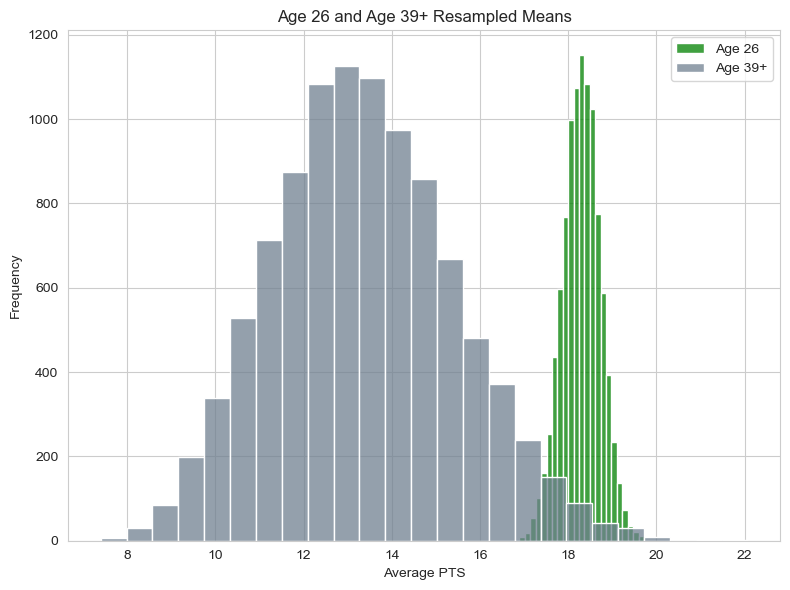

In [12]:
plt.figure(figsize=(8, 6))

sns.histplot(age_26_means, bins=25, color="green", label="Age 26")
sns.histplot(age_39_plus_means, bins=25, color="slategrey", label="Age 39+")

plt.title("Age 26 and Age 39+ Resampled Means")
plt.xlabel("Average PTS")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

Indicated by the large spreads of the distribution for the resampled means of age 39+,
our confidence in the mean estimate is low—this is a result of small sample size.

### Assumptions and Potential Biases:
- Prior to 2006, NBA prospects were able to enter the league out of high school. Nowadays, players must be 19 years old to be eligible for the draft. This introduces some potential biases. It has been almost 20 years since an 18-year-old has played in the NBA, so the statistics could be misrepresentative of trends or changes in the NBA.
- Players who did get drafted out of high school as an 18-year-old were likely to be exceptional prospects and potentially may not be representative of the broader population.
- 18-year-old players likely do not have the complete performance data because they most likely played their first NBA games at least a few months after turning 18. Similarly, players in their 40s might be subject to missing or incomplete data due to reduced roles and/or playing time.
- The few players who have careers that last into their 40s are likely to be generational talents, potentially introducing survivorship bias.
- For 18-year-olds and players in their 40s, the small sample sizes introduce higher variability and reduced statistical power because there is simply less data available to work with.



We should assess whether the assumption of equal variances holds for our data to decide which type of t-test to perform.
We can use Levene’s Test to test the null hypothesis that multiple groups have equal variances.

In [13]:
f_stat, p_val_levene = levene(age_26, age_39_plus, center='mean')
print(f"Levene's Test Statistic: {f_stat:.4f}, p-value: {p_val_levene:.4f}")

Levene's Test Statistic: 0.0894, p-value: 0.7652


Since the p-value is > 0.05, the variances are equal across groups, and we fail to reject the null hypothesis.
Also, we should use Student’s t-test because it assumes the variances are equal.

In [14]:
t_stat, p_val_student = ttest_ind(age_26, age_39_plus)

print(f"Student's Test Statistic: {t_stat:.4f}, p-value: {p_val_student:.4f}")

Student's Test Statistic: 2.3398, p-value: 0.0202


Since the p-value is less than 0.05, we reject the null hypothesis.

Using the strong evidence gained through visual inspection and these tests,
we can feel confident enough to conclude
that there is a statistically significant difference in mean points scored between `age_26` and `age_39_plus` groups—regardless of any hesitations present in the assumptions and potential biases.

However, let’s broaden our approach by considering performance metrics other than `PTS`,
and also ensure that the age groups we selected aren’t misrepresenting our data.

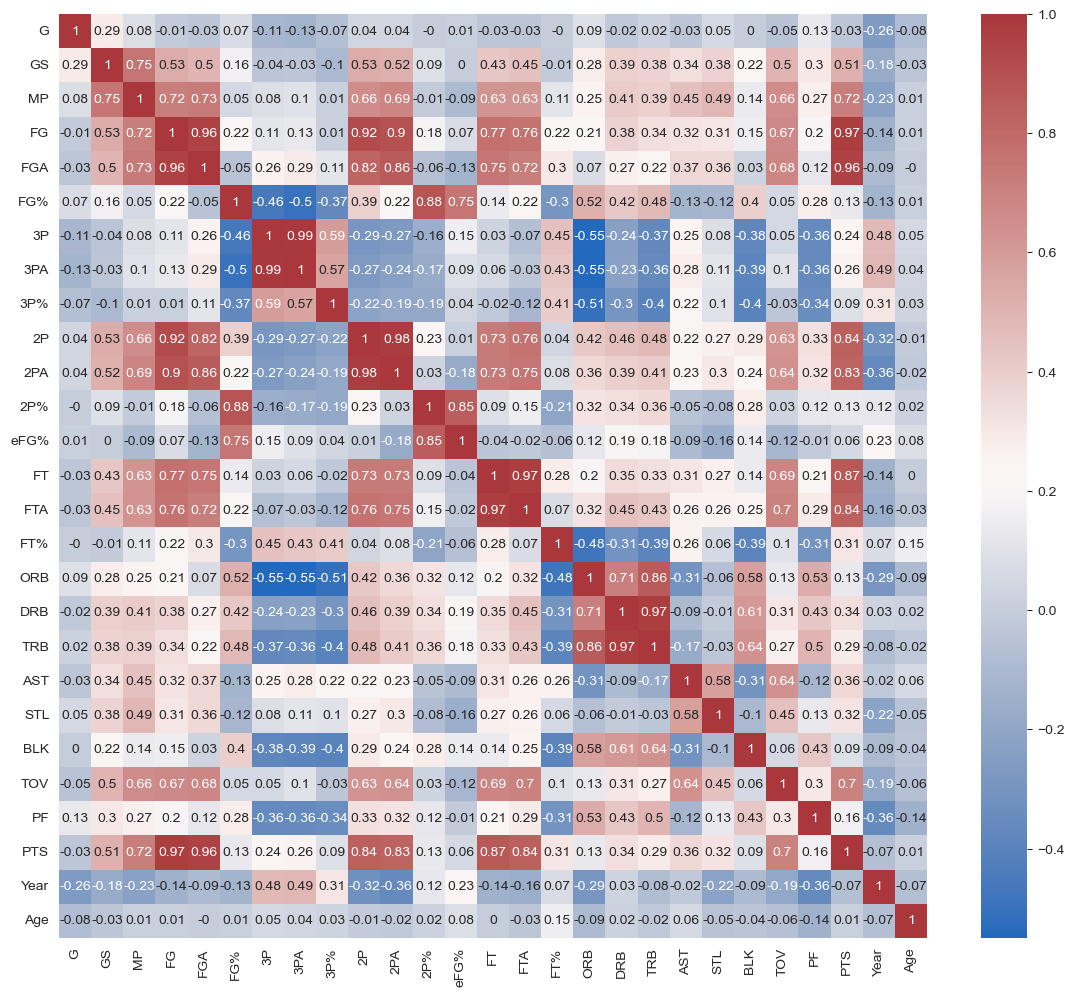

In [15]:
# Define target and features
target = 'Age'
features = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
            '3P', '3PA', '3P%', '2P', '2PA', '2P%',
            'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
            'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
            'PTS', 'Year']

nba_corr_subset = nba[features + [target]]

nba_corrs = nba_corr_subset.corr().round(2)

plt.figure(figsize=(14, 12))

sns.heatmap(nba_corrs, annot=True, cmap="vlag")
plt.show()

We’ll define an `add_jitter` function to make our data easier to visualize
since `sns.scatterplot` doesn't have a built-in `jitter` paramater like some other seaborn functions do.

In [16]:
def add_jitter(data, column, jitter_amount=0.5):
    return data[column] + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

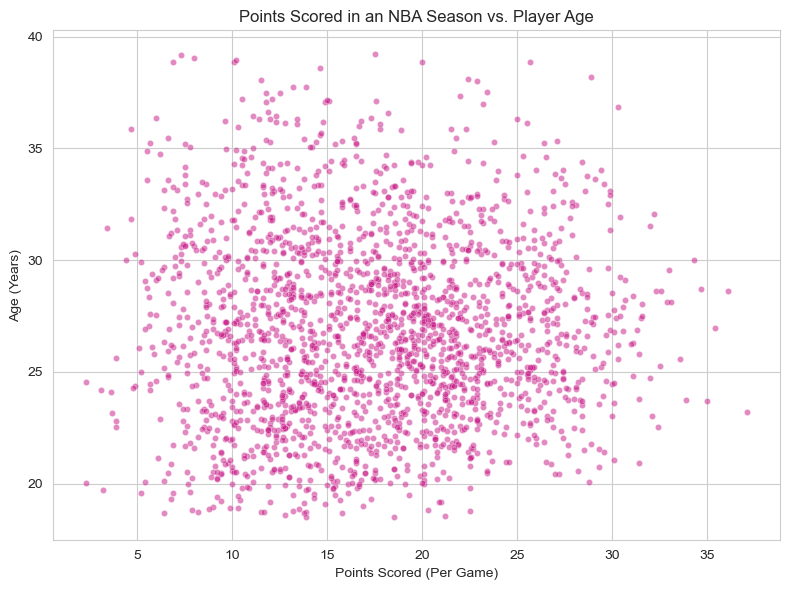

In [17]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=nba_corr_subset,
    x='PTS',
    y=add_jitter(nba_corr_subset, 'Age'),
    color='mediumvioletred',
    s=20,
    alpha=0.5,
)

plt.title('Points Scored in an NBA Season vs. Player Age')
plt.xlabel('Points Scored (Per Game)')
plt.ylabel('Age (Years)')

plt.tight_layout()
plt.show()

There's a lot of data to look at here,
but it appears that there may be a slight positive relationship between `PTS` and `Age`, on average.
Before we add too much complexity, let’s try to fit a simple linear regression model to this data.

In [18]:
xs = np.linspace(np.min(nba['PTS']), np.max(nba['PTS']), 100)

lin_reg_model = LinearRegression()
lin_reg = lin_reg_model.fit(nba[['PTS']], nba['Age'])

b0 = lin_reg.intercept_
b1 = lin_reg.coef_

preds = b0 + b1*xs

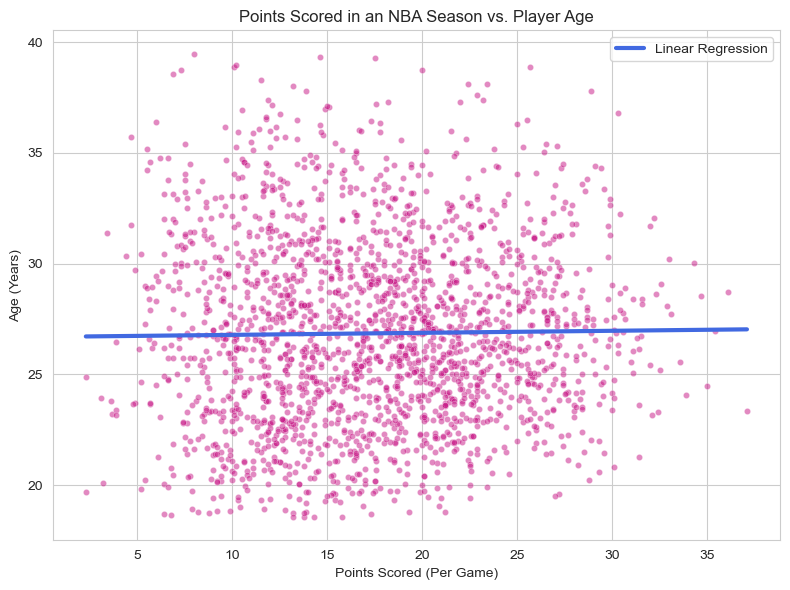

In [19]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=nba_corr_subset,
    x='PTS',
    y=add_jitter(nba_corr_subset, 'Age'),
    color='mediumvioletred',
    s=20,
    alpha=0.5,
)

sns.lineplot(
    x=xs,
    y=preds,
    color='royalblue',
    linewidth=3,
    label='Linear Regression',
)

plt.title('Points Scored in an NBA Season vs. Player Age')
plt.xlabel('Points Scored (Per Game)')
plt.ylabel('Age (Years)')

plt.tight_layout()
plt.show()

Let’s see how well this model performed:

In [20]:
X = nba[['PTS']]
X = sm.add_constant(X)

sm_model = sm.OLS(nba['Age'], X).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4187
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.518
Time:                        23:56:29   Log-Likelihood:                -6017.7
No. Observations:                2122   AIC:                         1.204e+04
Df Residuals:                    2120   BIC:                         1.205e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6899      0.265    100.831      0.0

Not good—a 0.0 R-squared value.
However, with over 30 columns in the full dataset, we have plenty of features left to experiment with.
So, let’s plan out our approach.